In [1]:
import pandas as pd
import numpy as np

In [2]:
def create_binary_combinations(n):
    # Loop through all numbers from 0 to 2^n - 1
    r = []
    for i in range(1 << n):
        # Convert the current number to a binary string of length n
        binary_str = format(i, '0' + str(n) + 'b')
        r.append(binary_str)
    return r

In [3]:
masks = {}
negative_masks = {}
target_masks = {}
full_masks = {}
for i in range(1,17):
    mask = np.array([[*s] for s in create_binary_combinations(i)[:-1]], dtype=int).astype(bool) # need double type conversion to keep '0' -> False
    masks[i] = mask
    negative_masks[i] = ~mask
    targets_mask_proxy = (negative_masks[i] * np.arange(1, i+1)).reshape(-1)
    target_masks[i] = np.delete(targets_mask_proxy,np.where(targets_mask_proxy == 0)) - 1
    full_masks[i] = np.repeat(mask, mask.shape[1]-np.sum(mask, axis=1), axis=0)

In [4]:
sizes = [(n, mask.shape[0]) for (n, mask) in full_masks.items()]
df_sizes = pd.DataFrame(sizes).set_index(0)
df_sizes.columns = ['rows_per_word']
df_sizes

,rows_per_word
0,
1,1
2,4
3,12
4,32
5,80
6,192
7,448
8,1024
9,2304


In [5]:
data = pd.read_csv('data/words_alpha.txt',header=None)
data[0] = data[0].astype(str)

Max word length: 31


<Axes: >

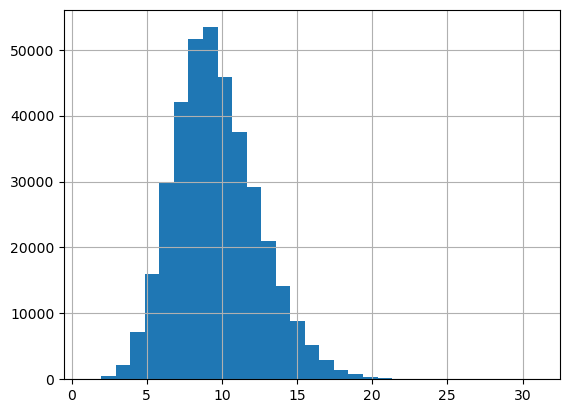

In [6]:
print('Max word length:',data[0].str.len().max())
data[0].str.len().hist(bins=31)

In [7]:
data['n_unique_letters'] = data[0].apply(lambda x: len(set(x)))

Max unique letters:  16


<Axes: >

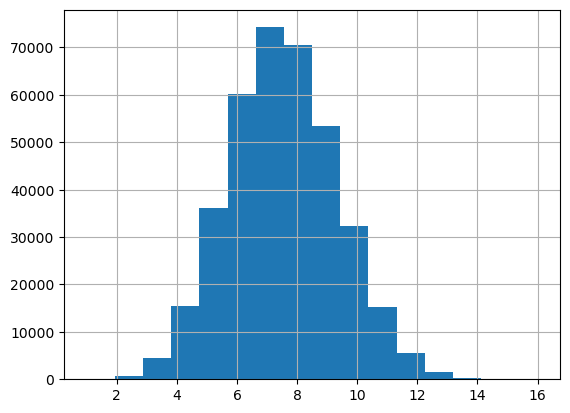

In [8]:
print('Max unique letters: ', data['n_unique_letters'].max())
data['n_unique_letters'].hist(bins=16)

In [9]:
x = pd.merge(pd.DataFrame(data['n_unique_letters'].value_counts()).rename(columns={'n_unique_letters':'n_words'}), df_sizes, how='outer', left_index=True, right_index=True)
x['n_rows'] = x['n_words'] * x['rows_per_word']
n_rows = x['n_rows'].sum()
print(f'Total number of rows: {n_rows:,}')
# Assume that target will be saved as uint8
x['memory_targets_mb'] = x['n_rows'] * 8 / 8 / 1024 / 1024 
# Assume that words will be saved in ASCII since we use only English letter, so it will be 8 bits
# Then, we take 32 window size to estimate upper bound
x['memory_features_mb'] = x['n_rows'] * 8 * 32 / 8 / 1024 / 1024 
mt = x['memory_targets_mb'].sum()
mi = x['memory_features_mb'].sum()
nte = x['n_rows'].sum()
print(f'Required memory for targets: {mt:.0f} MB,\nRequired memory for inputs: {mi:,.0f} MB')
print(f'Number of training examples: {nte:,}')
x

Total number of rows: 844,383,096
Required memory for targets: 805 MB,
Required memory for inputs: 25,769 MB
Number of training examples: 844,383,096


,n_words,rows_per_word,n_rows,memory_targets_mb,memory_features_mb
1,44,1,44,0.000042,0.001343
2,749,4,2996,0.002857,0.091431
3,4458,12,53496,0.051018,1.632568
4,15433,32,493856,0.470978,15.071289
5,36100,80,2888000,2.754211,88.134766
6,60122,192,11543424,11.008667,352.277344
7,74265,448,33270720,31.729431,1015.341797
8,70430,1024,72120320,68.779297,2200.937500
9,53537,2304,123349248,117.635010,3764.320312
10,32443,5120,166108160,158.413086,5069.218750
